# 03 Running a simulation

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import ecm
import liionpack as lp
import pybamm
import numpy as np

In [2]:
pybamm.__version__

'23.9'

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-13 17:18:13,697
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-13 17:18:13,732
------------------------------------------------------------
------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2024-02-13 17:18:13,739
------------------------------------------------------------


{'alpha_radial': 0.0001303942258261954, 'alpha_spiral': 0.0016796913048851415, 'lump_rho': 2499.3162844229373, 'lump_Cp': 8241.745114621628}


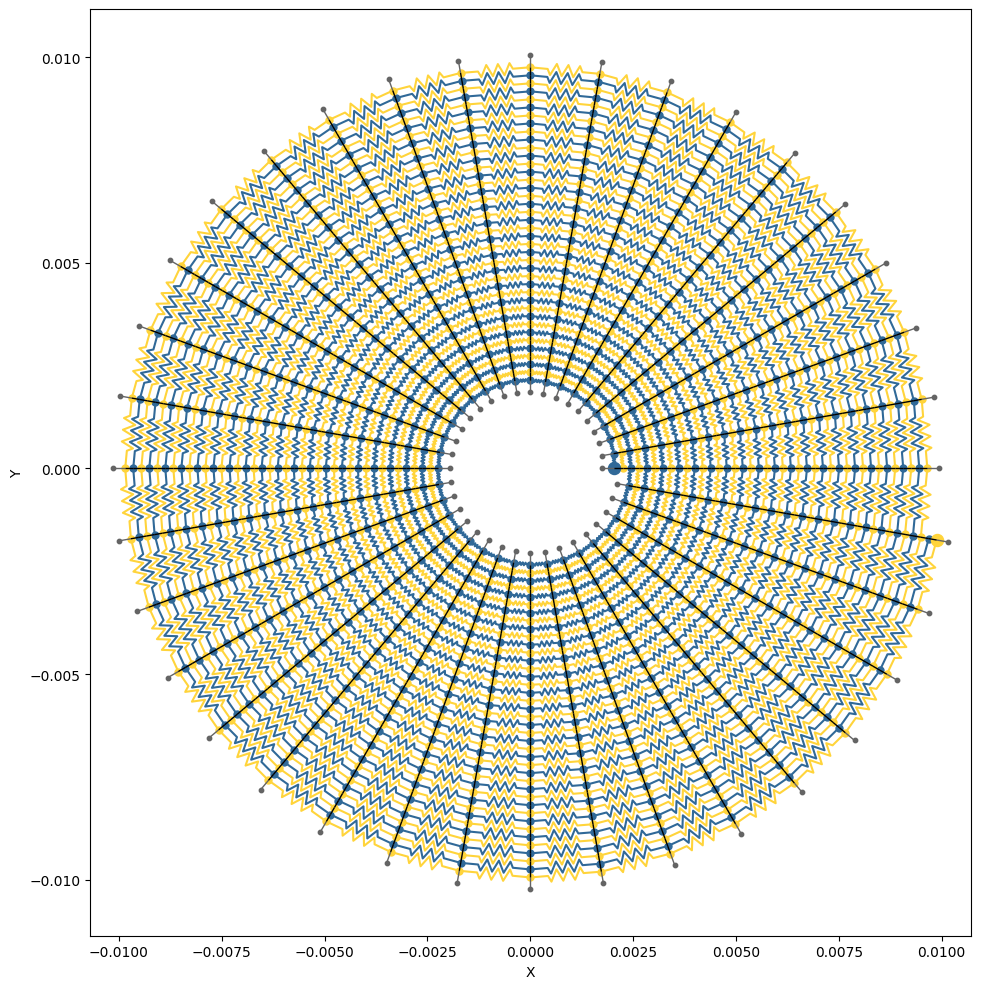

In [3]:
# pybamm.set_logging_level("INFO")
wrk = op.Workspace()
wrk.clear()

# Geometry of spiral
Nlayers = 20
dtheta = 10
spacing = 195e-6  # To do should come from params
inner_r = 10 * spacing
pos_tabs = [-1]
neg_tabs = [0]
length_3d = 0.08
tesla_tabs = False

# Experiment
I_app = 4.0
dt = 5
Nsteps = 360
hours = dt * Nsteps / 3600
experiment = pybamm.Experiment(
    [
        f"Discharge at {I_app} A for {hours} hours",
    ],
    period=f"{dt} seconds",
)

# OpenPNM project
project, arc_edges = ecm.make_spiral_net(Nlayers,
                                         dtheta,
                                         spacing,
                                         inner_r,
                                         pos_tabs,
                                         neg_tabs,
                                         length_3d,
                                         tesla_tabs)
ecm.plot_topology(project.network)
# Parameter set
param = pybamm.ParameterValues("Marquis2019")
# JellyBaMM discretises the spiral using the electrode height for spiral length
# This parameter set has the longer length set to the Electrode width
# We want to swap this round
param['Electrode width [m]'] = length_3d
# Passing None as initial_soc will take values from Parameter set and apply
# uniformly everywhere
initial_soc = 0.5
thermal_props = print(ecm.lump_thermal_props(param))



In [4]:
# model = pybamm.lithium_ion.SPMe(options={"thermal": "lumped"})

# model.variable_names()

param.search('heat transfer')

Edge heat transfer coefficient [W.m-2.K-1]	0.3
Negative current collector surface heat transfer coefficient [W.m-2.K-1]	0.0
Negative tab heat transfer coefficient [W.m-2.K-1]	10.0
Positive current collector surface heat transfer coefficient [W.m-2.K-1]	0.0
Positive tab heat transfer coefficient [W.m-2.K-1]	10.0
Total heat transfer coefficient [W.m-2.K-1]	10.0


In [5]:
#
# Liionpack solve
#
import os
import numpy as np
import ecm
import pybamm
import time as ticker
import openpnm as op
import liionpack as lp
from tqdm import tqdm
import matplotlib.pyplot as plt

# import configparser


wrk = op.Workspace()


def get_cc_power_loss(network, netlist):
    pnm_power = np.zeros(network.Nt)
    for i in range(network.Nt):
        T_map = netlist["pnm_throat_id"] == i
        pnm_power[i] = np.sum(netlist["power_loss"][T_map])
    return pnm_power


def fT_non_dim(parameter_values, T):
    param = pybamm.LithiumIonParameters()
    Delta_T = parameter_values.evaluate(param.Delta_T)
    T_ref = parameter_values.evaluate(param.T_ref)
    return (T - T_ref) / Delta_T


def do_heating():
    pass


def run_simulation_lp(parameter_values, experiment, initial_soc, project):
    ###########################################################################
    # Simulation information                                                  #
    ###########################################################################
    st = ticker.time()
    max_workers = int(os.cpu_count() / 2)
    # hours = config.getfloat("RUN", "hours")
    # try:
    # dt = config.getfloat("RUN", "dt")
    # Nsteps = int(np.ceil(hours * 3600 / dt) + 1)
    # except configparser.NoOptionError:
    # dt = 30
    # Nsteps = int(hours * 60 * 2) + 1  # number of time steps
    net = project.network
    phase = project.phases()["phase_01"]
    # The jellyroll layers are double sided around the cc except for the inner
    # and outer layers the number of spm models is the number of throat
    # connections between cc layers
    Nspm = net.num_throats("spm_resistor")
    res_Ts = net.throats("spm_resistor")
    # sorted_res_Ts = net["throat.spm_resistor_order"][res_Ts].argsort()
    # print("Total Electrode Height", np.around(np.sum(electrode_heights), 2), "m")
    # Take I_app from first command of the experiment
    proto = lp.generate_protocol_from_experiment(experiment)
    I_app = proto[0]
    I_typical = I_app / Nspm

    # print("Total pore volume", np.sum(net["pore.volume"]))
    # print("Mean throat area", np.mean(net["throat.area"]))
    # print("Num throats", net.num_throats())
    # print("Num throats SPM", Nspm)
    # print("Num throats pos_cc", net.num_throats("pos_cc"))
    # print("Num throats neg_cc", net.num_throats("neg_cc"))
    # print("Typical height", typical_height)
    # print("Typical current", I_typical)
    ###########################################################################
    # Make the pybamm simulation - should be moved to a simfunc               #
    ###########################################################################
    parameter_values = ecm.adjust_parameters(parameter_values, I_typical)
    # width = parameter_values["Electrode width [m]"]
    # t1 = parameter_values["Negative electrode thickness [m]"]
    # t2 = parameter_values["Positive electrode thickness [m]"]
    # t3 = parameter_values["Negative current collector thickness [m]"]
    # t4 = parameter_values["Positive current collector thickness [m]"]
    # t5 = parameter_values["Separator thickness [m]"]
    # ttot = t1 + t2 + t3 + t4 + t5
    # A_cc = electrode_heights * width
    # bat_vol = np.sum(A_cc * ttot)
    # print("BATTERY ELECTRODE VOLUME", bat_vol)
    # print("18650 VOLUME", 0.065 * np.pi * ((8.75e-3) ** 2 - (2.0e-3) ** 2))
    ###########################################################################
    # Output variables                                                        #
    ###########################################################################
    output_variables = ecm.output_variables()
    ###########################################################################
    # Thermal parameters                                                      #
    ###########################################################################
    T0 = parameter_values["Initial temperature [K]"]
    lumpy_therm = ecm.lump_thermal_props(parameter_values)
    cp = lumpy_therm["lump_Cp"]
    rho = lumpy_therm["lump_rho"]
    ###########################################################################
    # Run time config                                                         #
    ###########################################################################
    # outer_step = 0
    # if config.getboolean("PHYSICS", "do_thermal"):
    # Always do thermal
    ecm.setup_thermal(project, parameter_values)
    # try:
    #     thermal_third = config.getboolean("RUN", "third")
    # except KeyError:
    thermal_third = False
    ###########################################################################
    # New Liionpack code                                                      #
    ###########################################################################
    dim_time_step = 10
    neg_econd, pos_econd = ecm.cc_cond(project, parameter_values)
    Rs = 1e-2  # series resistance
    Ri = 90  # initial guess for internal resistance
    V = 3.6  # initial guess for cell voltage
    # I_app = 0.5
    netlist = ecm.network_to_netlist(net, Rs, Ri, V, I_app)
    T0 = parameter_values["Initial temperature [K]"]
    e_heights = net["throat.electrode_height"][net.throats("throat.spm_resistor")]
    spm_temperature = np.ones(Nspm) * T0
    # e_heights.fill(np.mean(e_heights))
    inputs = {
        "Electrode height [m]": e_heights,
        "Input temperature [K]": spm_temperature
    }
    ###########################################################################
    # Initialisation
    experiment_init = pybamm.Experiment(
        [
            f"Discharge at {I_app} A for 4 seconds",
        ],
        period="1 second",
    )
    # Solve the pack
    manager = lp.CasadiManager()
    manager.solve(
        netlist=netlist,
        sim_func=lp.thermal_external,
        parameter_values=parameter_values,
        experiment=experiment_init,
        output_variables=output_variables,
        inputs=inputs,
        nproc=max_workers,
        initial_soc=initial_soc,
        setup_only=True,
    )
    Qvar = "Volume-averaged total heating [W.m-3]"
    Qid = np.argwhere(np.asarray(manager.variable_names) == Qvar).flatten()[0]
    lp.logger.notice("Starting initial step solve")
    vlims_ok = True
    tic = ticker.time()
    netlist["power_loss"] = 0.0
    plt.figure()
    with tqdm(total=manager.Nsteps, desc="Initialising simulation") as pbar:
        step = 0
        # reset = True
        while step < manager.Nsteps and vlims_ok:
            ###################################################################
            print(spm_temperature)
            updated_inputs = {"Input temperature [K]": spm_temperature}
            vlims_ok = manager._step(step, updated_inputs)
            ###################################################################
            # Apply Heat Sources
            Q_tot = manager.output[Qid, step, :]
            Q = get_cc_power_loss(net, netlist)
            print(Q_tot)
            print(Q)
            # To do - Get cc heat from netlist
            # Q_ohm_cc = net.interpolate_data("pore.cc_power_loss")[res_Ts]
            # Q_ohm_cc /= net["throat.volume"][res_Ts]
            # key = "Volume-averaged Ohmic heating CC [W.m-3]"
            # vh[key][outer_step, :] = Q_ohm_cc[sorted_res_Ts]
            Q[res_Ts] += Q_tot
            ecm.apply_heat_source_lp(project, Q)
            # Calculate Global Temperature
            ecm.run_step_transient(project, dim_time_step, T0, cp, rho, thermal_third)
            # Interpolate the node temperatures for the SPMs
            spm_temperature = phase.interpolate_data("pore.temperature")[res_Ts]
            T_non_dim_spm = fT_non_dim(parameter_values, spm_temperature)
            print(T_non_dim_spm)
            ###################################################################
            step += 1
            pbar.update(1)
            temp_Ri = np.array(netlist.loc[manager.Ri_map].value)
            plt.scatter(np.arange(len(temp_Ri)), temp_Ri, label=str(step))
    plt.legend()
    manager.step = step
    toc = ticker.time()
    lp.logger.notice("Initial step solve finished")
    lp.logger.notice("Total stepping time " + str(np.around(toc - tic, 3)) + "s")
    lp.logger.notice(
        "Time per step " + str(np.around((toc - tic) / manager.Nsteps, 3)) + "s"
    )
    ###########################################################################
    # Real Solve
    ###########################################################################
    spm_temperature = np.ones(Nspm) * T0
    inputs.update({"Input temperature [K]": spm_temperature})
    # Solve the pack
    manager = lp.CasadiManager()
    manager.solve(
        netlist=netlist,
        sim_func=lp.thermal_external,
        parameter_values=parameter_values,
        experiment=experiment,
        output_variables=output_variables,
        inputs=inputs,
        nproc=max_workers,
        initial_soc=initial_soc,
        setup_only=True,
    )
    Qvar = "Volume-averaged total heating [W.m-3]"
    Qid = np.argwhere(np.asarray(manager.variable_names) == Qvar).flatten()[0]
    lp.logger.notice("Starting step solve")
    vlims_ok = True
    tic = ticker.time()
    netlist["power_loss"] = 0.0
    with tqdm(total=manager.Nsteps, desc="Stepping simulation") as pbar:
        step = 0
        # reset = True
        while step < manager.Nsteps and vlims_ok:
            ###################################################################
            print(spm_temperature)
            updated_inputs = {"Input temperature [K]": spm_temperature}
            vlims_ok = manager._step(step, updated_inputs)
            ###################################################################
            # Apply Heat Sources
            Q_tot = manager.output[Qid, step, :]
            Q = get_cc_power_loss(net, netlist)
            # To do - Get cc heat from netlist
            # Q_ohm_cc = net.interpolate_data("pore.cc_power_loss")[res_Ts]
            # Q_ohm_cc /= net["throat.volume"][res_Ts]
            # key = "Volume-averaged Ohmic heating CC [W.m-3]"
            # vh[key][outer_step, :] = Q_ohm_cc[sorted_res_Ts]
            Q[res_Ts] += Q_tot
            ecm.apply_heat_source_lp(project, Q)
            # Calculate Global Temperature
            ecm.run_step_transient(project, dim_time_step, T0, cp, rho, thermal_third)
            # Interpolate the node temperatures for the SPMs
            spm_temperature = phase.interpolate_data("pore.temperature")[res_Ts]
            ###################################################################
            step += 1
            pbar.update(1)
    manager.step = step
    toc = ticker.time()
    lp.logger.notice("Step solve finished")
    lp.logger.notice("Total stepping time " + str(np.around(toc - tic, 3)) + "s")
    lp.logger.notice(
        "Time per step " + str(np.around((toc - tic) / manager.Nsteps, 3)) + "s"
    )

    print("*" * 30)
    print("ECM Sim time", ticker.time() - st)
    print("*" * 30)
    return project, manager.step_output()

/Users/tleo/micromamba/envs/pnm_dev_pinned_intel/lib/python3.10/site-packages/pybamm/models/full_battery_models/base_battery_model.py:910: OptionWarning: The 'lumped' thermal option with 'dimensionality' 0 now uses the parameters 'Cell cooling surface area [m2]', 'Cell volume [m3]' and 'Total heat transfer coefficient [W.m-2.K-1]' to compute the cell cooling term, regardless of the value of the the 'cell geometry' option. Please update your parameters accordingly.
  options = BatteryModelOptions(extra_options)
Initialising simulation:   0%|          | 0/5 [00:00<?, ?it/s]

[68029.79   67495.97   66968.914  ...  6538.5366  6529.979   6521.458 ]
[2.38313237e-08 2.39609926e-08 2.40906624e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Initialising simulation:  20%|██        | 1/5 [00:09<00:36,  9.05s/it]

[26434.525 26337.475 26241.209 ... 12512.034 12524.421 12536.94 ]
[1.41478280e-08 1.42630428e-08 1.43785616e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


Initialising simulation:  40%|████      | 2/5 [00:13<00:19,  6.63s/it]

[17545.545 17517.658 17489.906 ... 14822.674 14846.603 14870.682]
[1.16135995e-08 1.17216134e-08 1.18299551e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


Initialising simulation:  60%|██████    | 3/5 [00:18<00:11,  5.79s/it]

[15034.023 15023.83  15013.563 ... 15637.715 15666.245 15695.   ]
[1.08447664e-08 1.09502836e-08 1.10561880e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


Initialising simulation:  80%|████████  | 4/5 [00:22<00:05,  5.09s/it]

[14280.177 14275.371 14270.483 ... 15921.417 15951.493 15981.741]
[1.06069537e-08 1.07116837e-08 1.08168129e-08 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]


Stepping simulation: 100%|██████████| 361/361 [20:32<00:00,  3.41s/it]

******************************
ECM Sim time 1260.5922780036926
******************************


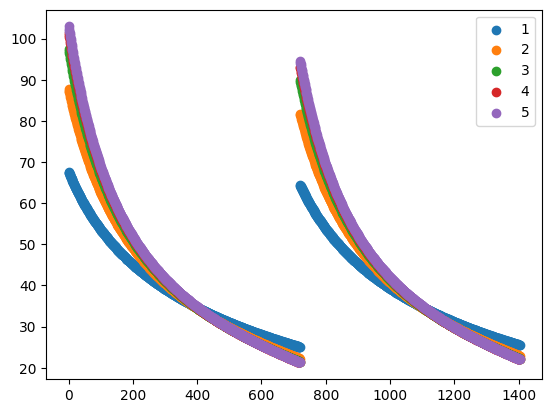

In [7]:
# Run simulation
project, output = ecm.run_simulation_lp(parameter_values=param,
                                        experiment=experiment,
                                        initial_soc=None,
                                        project=project)

In [8]:
net = project.network
net.num_pores('free_stream')

36

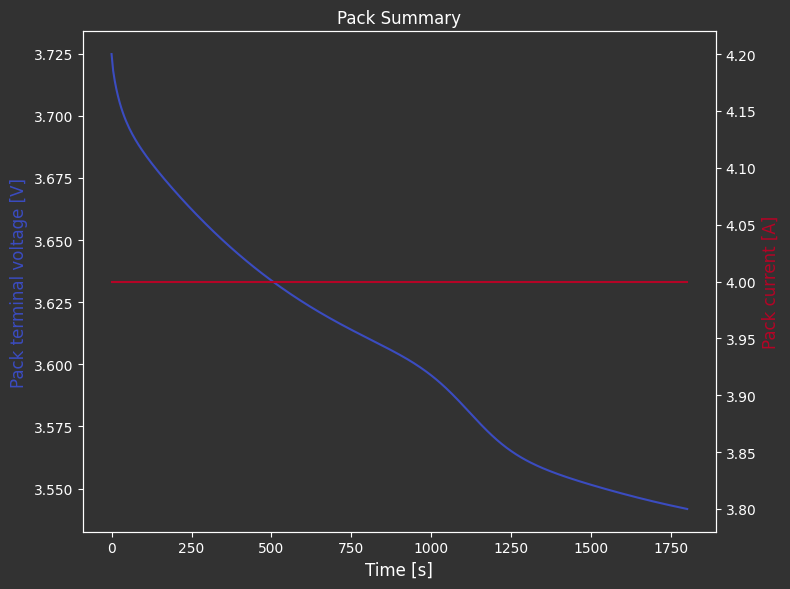

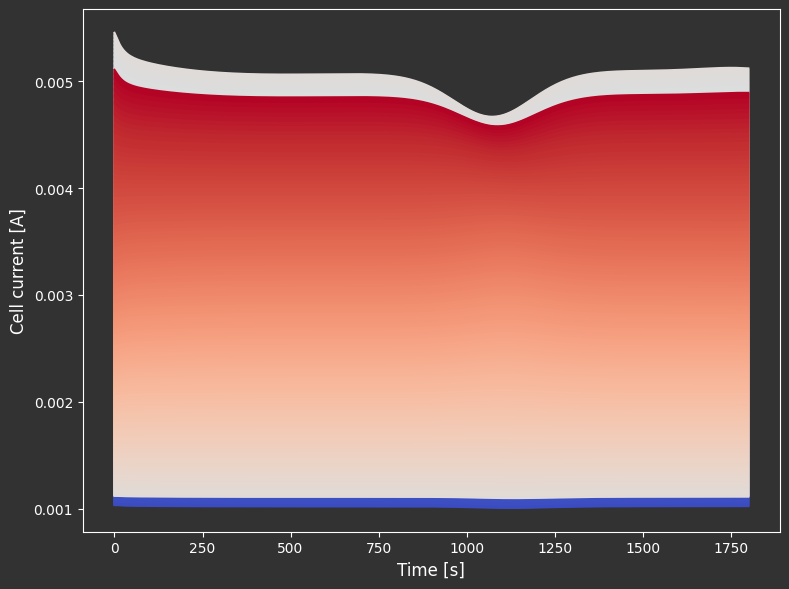

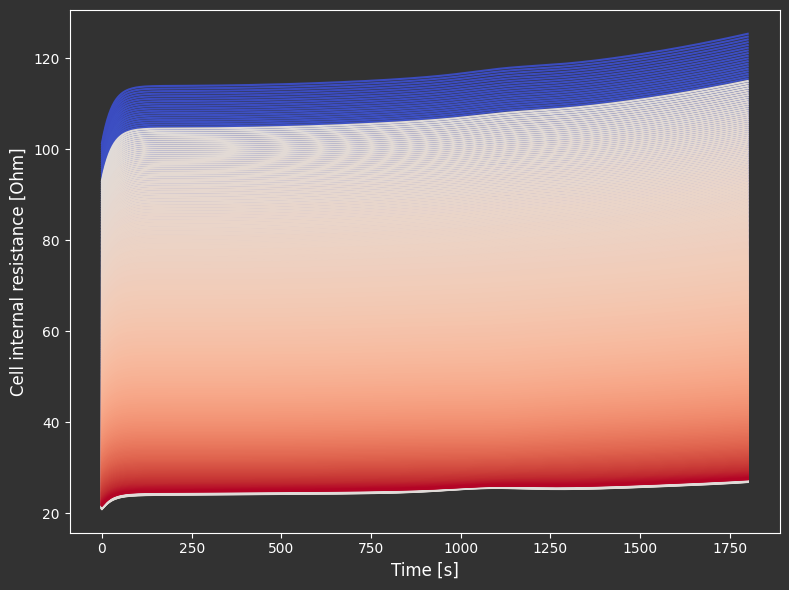

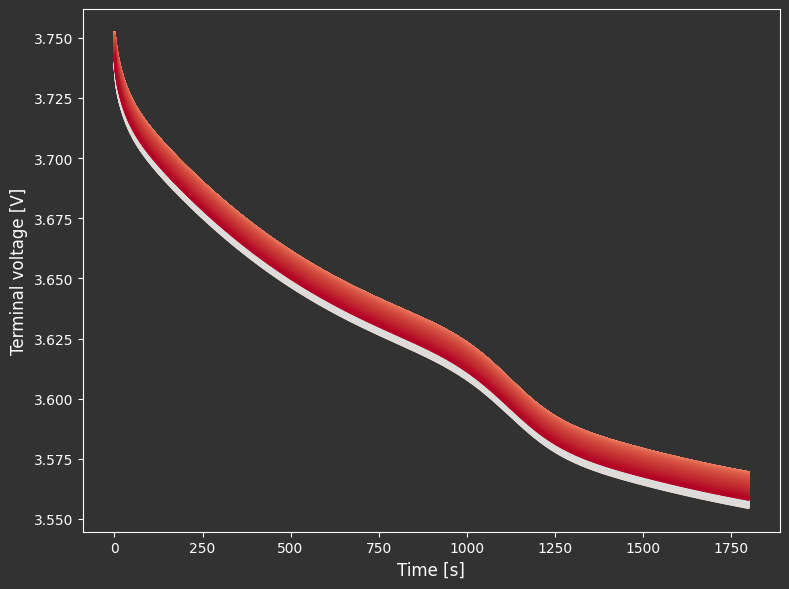

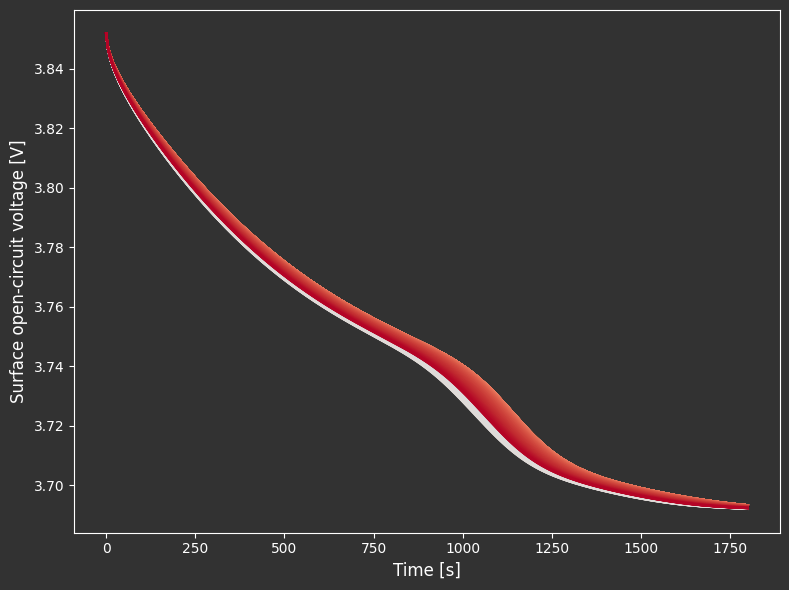

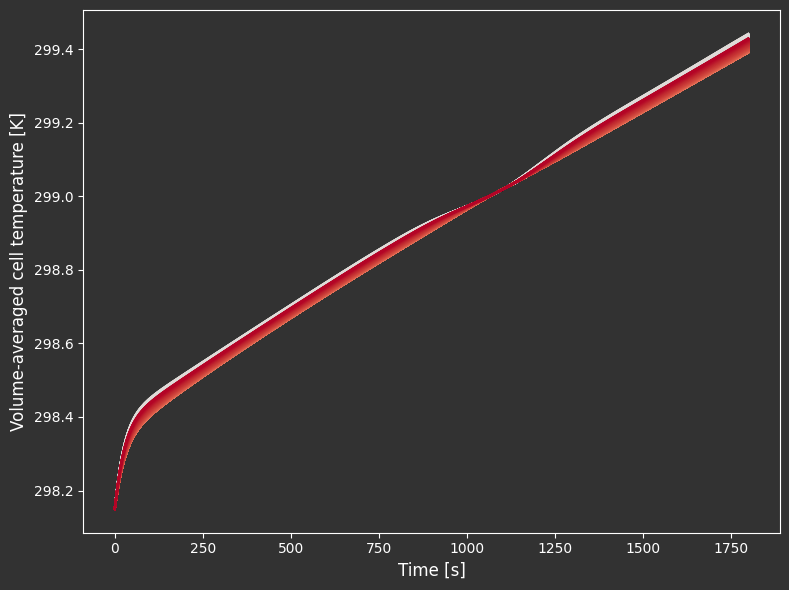

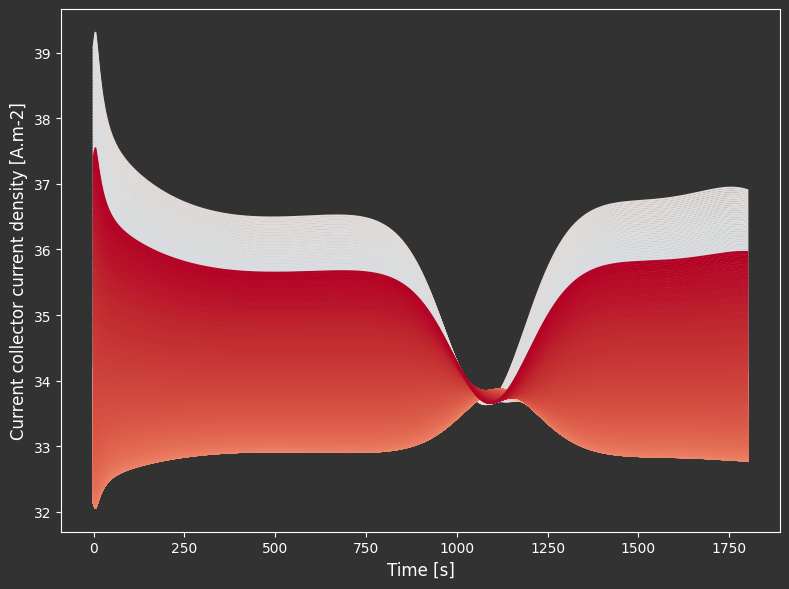

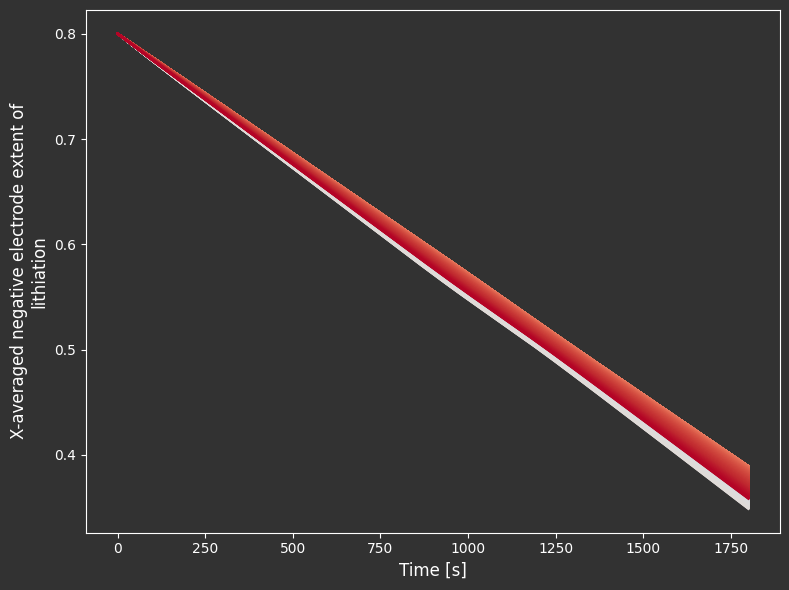

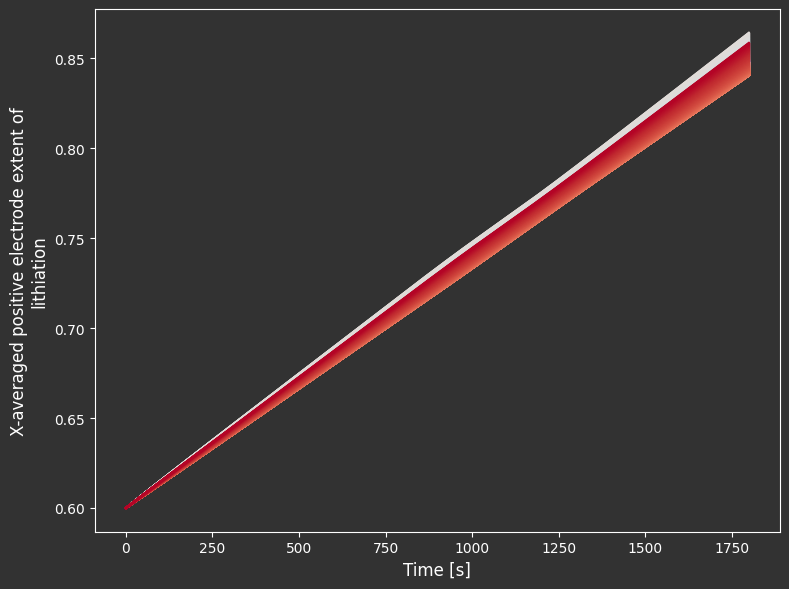

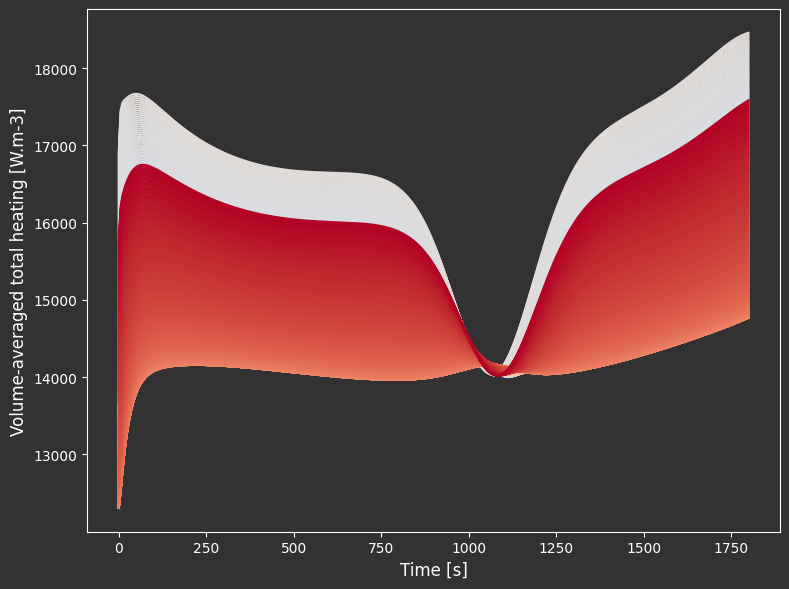

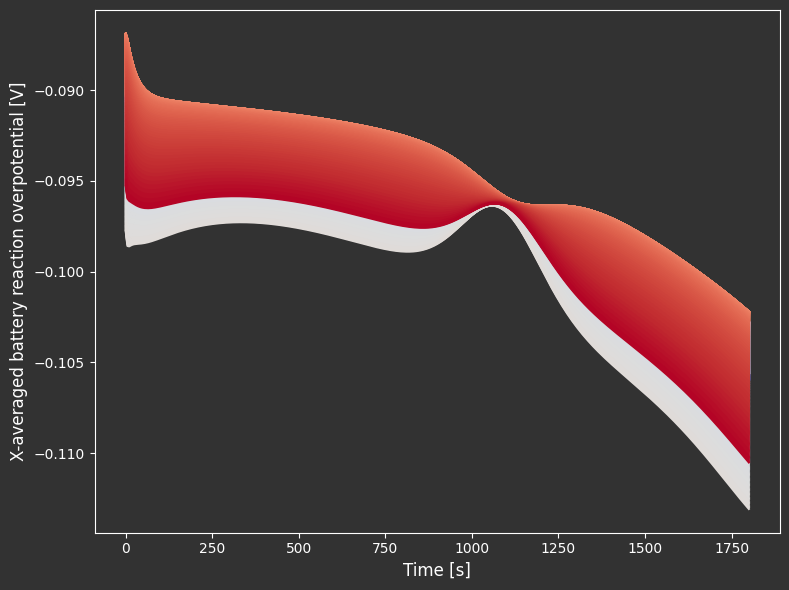

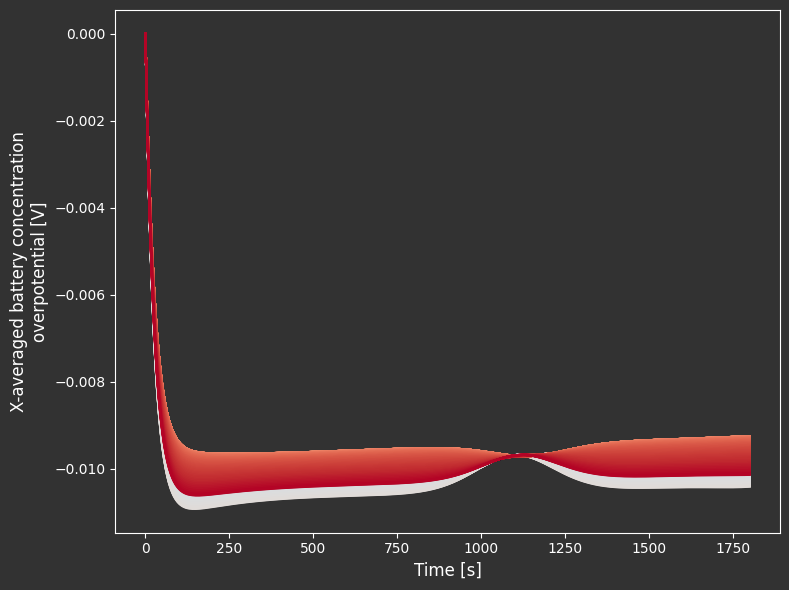

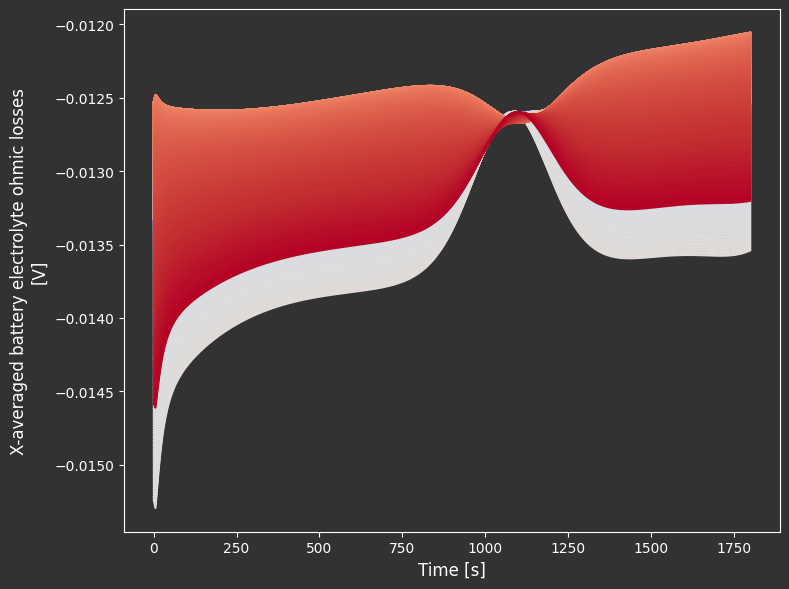

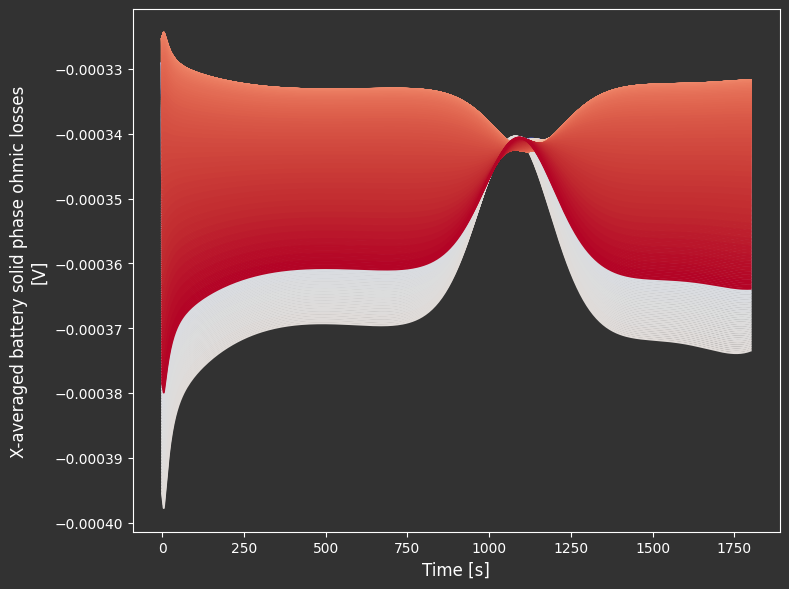

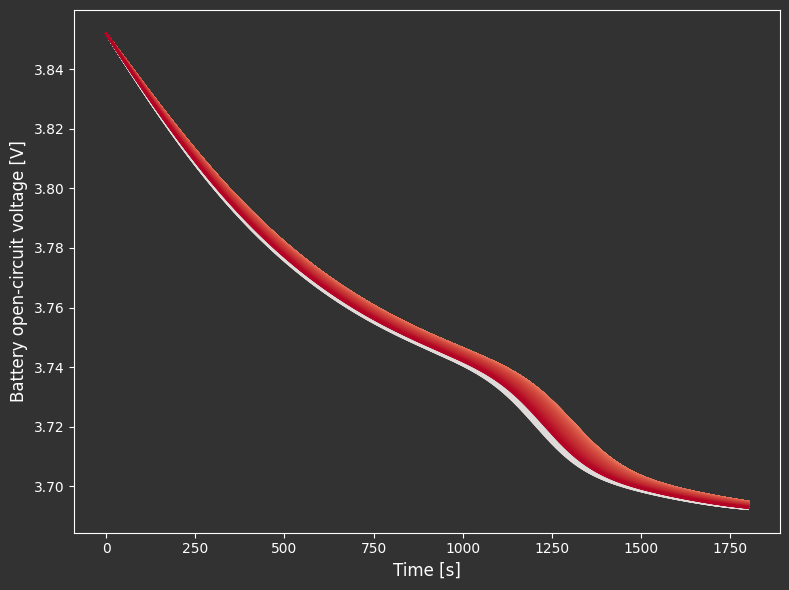

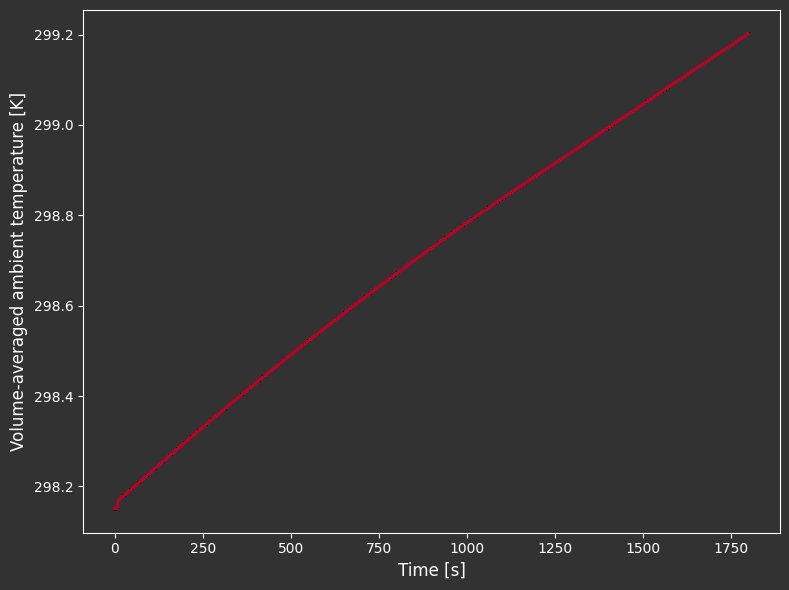

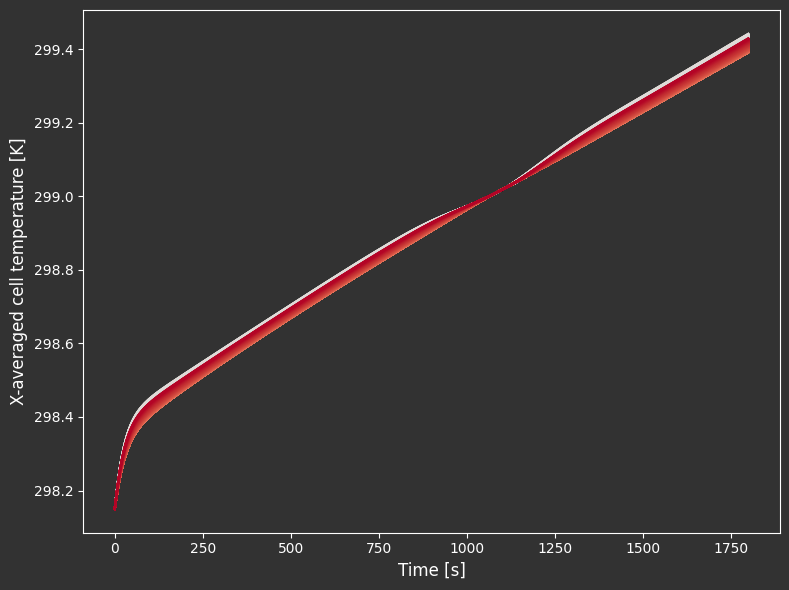

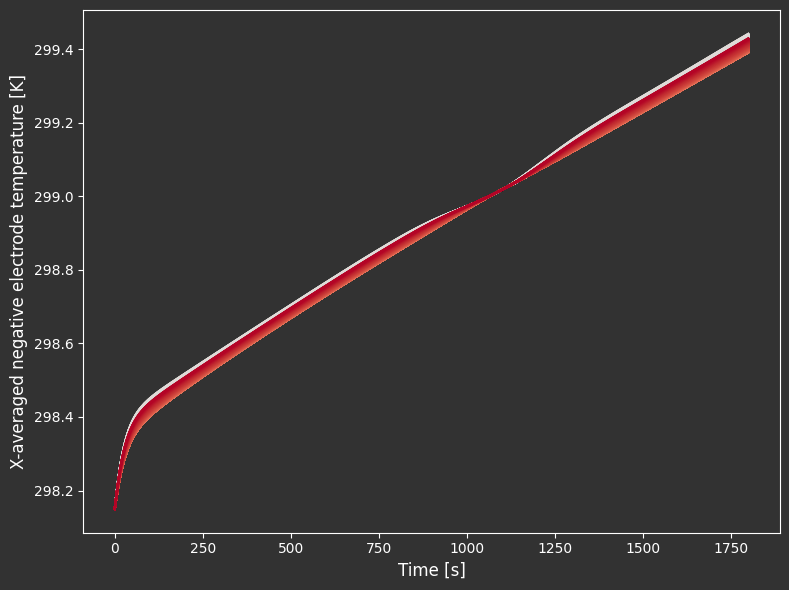

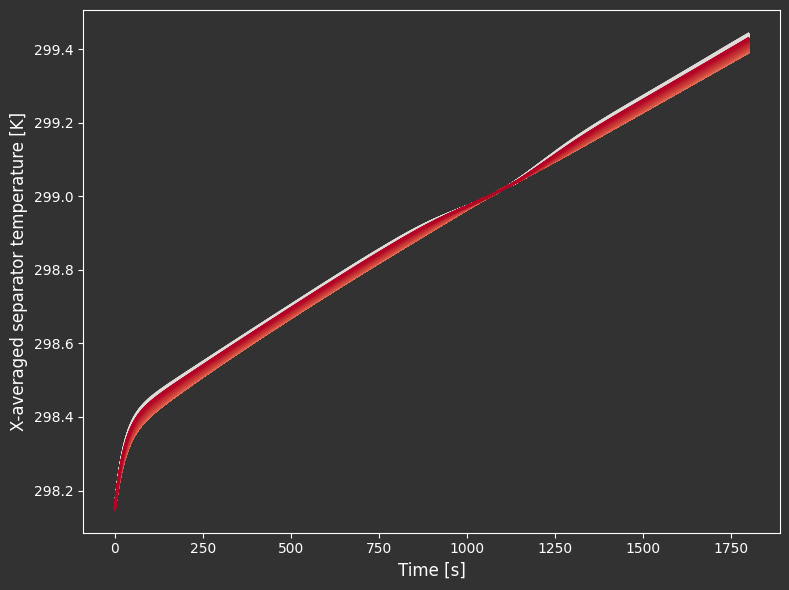

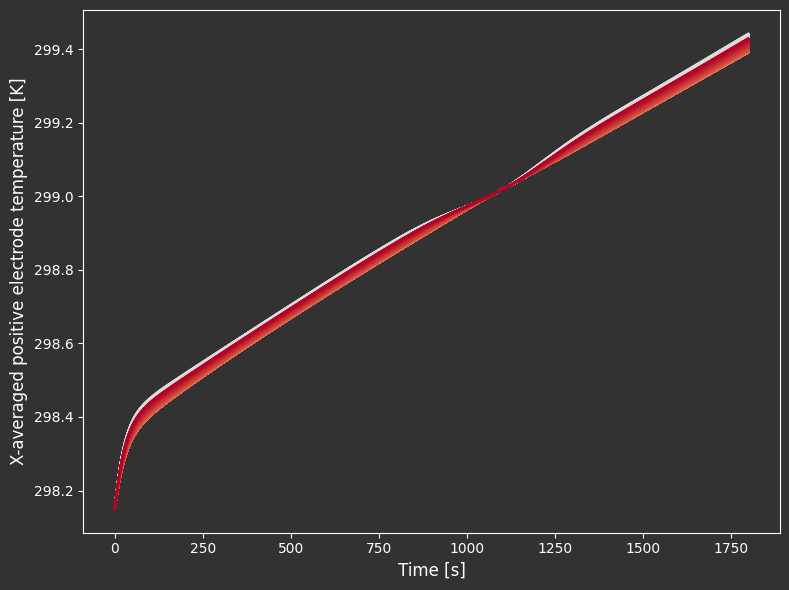

In [9]:
lp.plot_output(output)

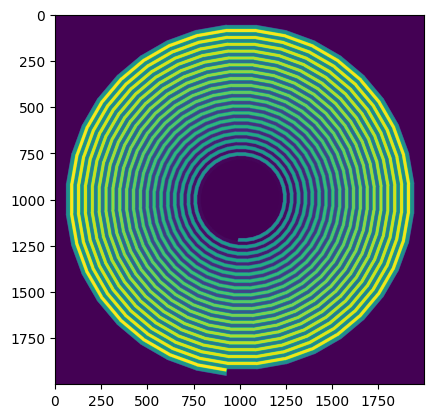

In [10]:
im_spm_map = ecm.interpolate_spm_number(project).astype(int)

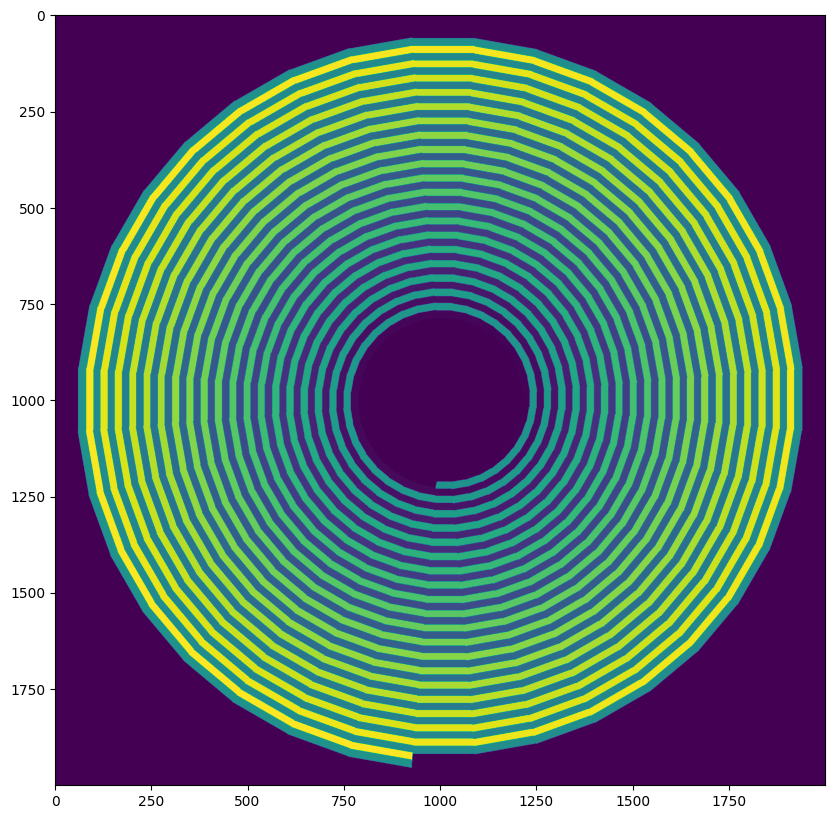

In [11]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(im_spm_map)

In [12]:
np.unique(im_spm_map)

array([  -1,    0,    1, ..., 1401, 1402, 1403])

In [13]:
mask = im_spm_map == -1

In [14]:
output.keys()

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Cell internal resistance [Ohm]', 'Terminal voltage [V]', 'Surface open-circuit voltage [V]', 'Volume-averaged cell temperature [K]', 'Current collector current density [A.m-2]', 'X-averaged negative electrode extent of lithiation', 'X-averaged positive electrode extent of lithiation', 'Volume-averaged total heating [W.m-3]', 'X-averaged battery reaction overpotential [V]', 'X-averaged battery concentration overpotential [V]', 'X-averaged battery electrolyte ohmic losses [V]', 'X-averaged battery solid phase ohmic losses [V]', 'Battery open-circuit voltage [V]', 'Volume-averaged ambient temperature [K]', 'X-averaged cell temperature [K]', 'X-averaged negative electrode temperature [K]', 'X-averaged separator temperature [K]', 'X-averaged positive electrode temperature [K]'])

In [15]:
t_data = output['Volume-averaged cell temperature [K]'][-1, :]
i_data = output['Current collector current density [A.m-2]'][-1, :]

In [16]:
arr = np.ones_like(im_spm_map).astype(float)

In [17]:
arr[~mask] = t_data[im_spm_map][~mask]
arr[mask] = np.nan

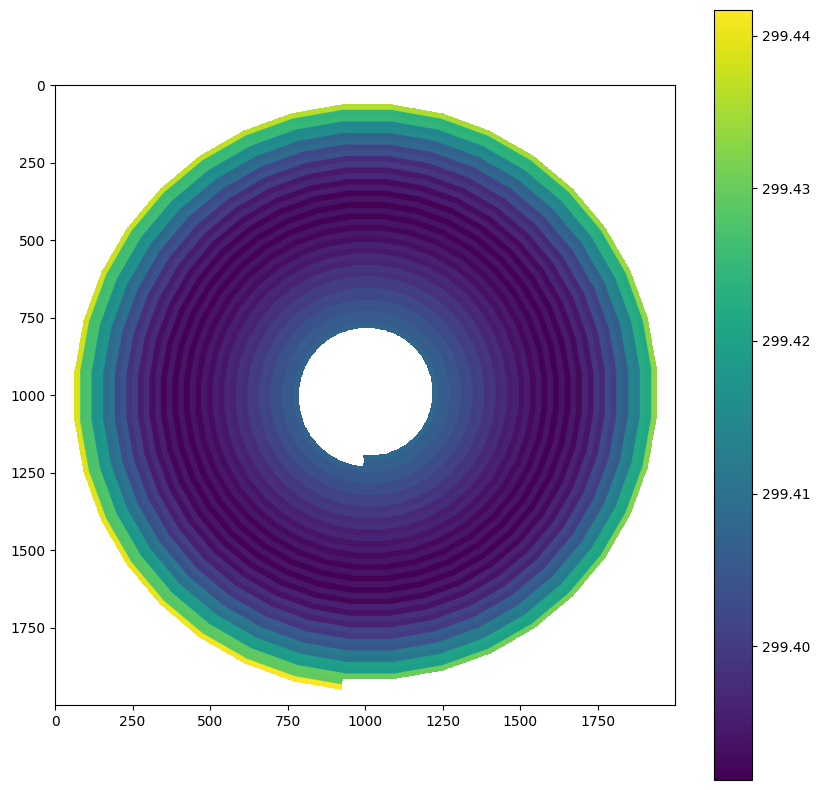

In [18]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
im = ax1.imshow(arr)
cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
cbar.ax.locator_params(nbins=6)

In [19]:
t_data.max() - t_data.min()


0.050445557

In [22]:
# create a gif from the images
import imageio
import os

def make_distr_gif(output,im_spm_map,variable='Volume-averaged cell temperature [K]',path='output.gif'):
    mask = im_spm_map == -1
    # the variable that you want to plot should be taken directly from the output
    all_data = output[variable]
    # all_t_data = output['Volume-averaged cell temperature [K]']
    # all_i_data = output['Current collector current density [A.m-2]']

    # the first index is the time index, the second index is the spatial index

    t0_t_data = all_data[0, :]
    n_timesteps = all_data.shape[0]

    # get the min and max temperature over all time points
    min_temp = np.min(all_data)
    max_temp = np.max(all_data)

    # make a matplotlib scalar mappable for colorbar scaling
    norm = plt.Normalize(min_temp, max_temp)


    # loop and pull out the array at each time step
    for i in range(n_timesteps):
        t_data = all_data[i, :]
        # i_data = all_i_data[i, :]
        # create an empty array of the same size as the spatial map
        arr = np.ones_like(im_spm_map).astype(float)
        # use the mask to fill in the array with the data at each time step
        arr[~mask] = t_data[im_spm_map][~mask]
        # set the array at the mask to nan
        arr[mask] = np.nan
        # plot the array and save an image, label the image with the time step
        fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
        norm = plt.Normalize(min_temp, max_temp)
        im = ax1.imshow(arr,norm=norm,cmap='viridis')
        cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
        cbar.ax.locator_params(nbins=6)
        plt.title(f"Time step {str(i).zfill(3)}")
        plt.savefig(f"output_{str(i).zfill(3)}.png")
        plt.clf()
        plt.close()


    # get the list of files
    files = sorted(os.listdir())
    # filter to only the png files
    files = [f for f in files if f.endswith(".png")]
    # read the images into a list
    images = [imageio.imread(f) for f in files]
    # write the images to a gif
    imageio.mimsave(path, images)
    # delete the images
    for f in files:
        os.remove(f)


make_distr_gif(output,im_spm_map,path='temp_output.gif')
    

In [27]:
# still in dev

import multiprocessing
import mpire
import imageio
import os

def process_time_step(t_data, im_spm_map, mask, min_temp, max_temp, i):
    arr = np.ones_like(im_spm_map).astype(float)
    arr[~mask] = t_data[im_spm_map][~mask]
    arr[mask] = np.nan
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
    norm = plt.Normalize(min_temp, max_temp)
    im = ax1.imshow(arr, norm=norm, cmap='viridis')
    cbar = plt.colorbar(im, orientation="vertical", format="%.2f")
    cbar.ax.locator_params(nbins=6)
    plt.title(f"Time step {str(i).zfill(3)}")
    plt.savefig(f"output_{str(i).zfill(3)}.png")
    plt.clf()
    plt.close()

def make_distr_gif(output, im_spm_map, variable='Volume-averaged cell temperature [K]', path='output.gif'):
    mask = im_spm_map == -1
    all_data = output[variable]
    t0_t_data = all_data[0, :]
    n_timesteps = all_data.shape[0]
    min_temp = np.min(all_data)
    max_temp = np.max(all_data)
    norm = plt.Normalize(min_temp, max_temp)

    pool = mpire.WorkerPool()
    results = []
    stacked_t_data = []
    for i in range(n_timesteps):
        t_data = all_data[i, :]
        stacked_t_data.append(t_data)
    result = pool.imap_unordered(process_time_step, (stacked_t_data, im_spm_map, mask, min_temp, max_temp, i))
    # results.append(result)

    # pool.close()
    pool.join()

    files = sorted(os.listdir())
    files = [f for f in files if f.endswith(".png")]
    images = [imageio.imread(f) for f in files]
    imageio.mimsave(path, images)
    for f in files:
        os.remove(f)

make_distr_gif(output, im_spm_map, path='temp_output_mp.gif')
    

ValueError: need at least one array to stack